In [1]:
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.measure import regionprops
from scipy.ndimage import distance_transform_edt, maximum_filter
from skimage.segmentation import watershed
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from scipy import ndimage as ndi
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import PIL.Image as Image
from skimage import io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


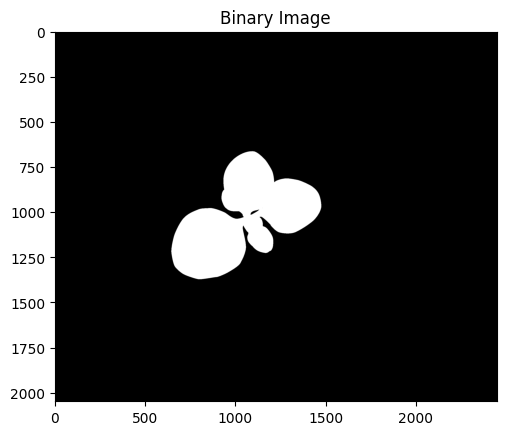

(2048, 2448)


In [3]:
image = Image.open("/content/drive/MyDrive/plant016.png")
#Convert the image file to a matrix
image = np.array(image)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap=plt.get_cmap('gray'))
plt.title('Binary Image')
plt.show()
print(thresh1.shape)

(-0.5, 2447.5, 2047.5, -0.5)

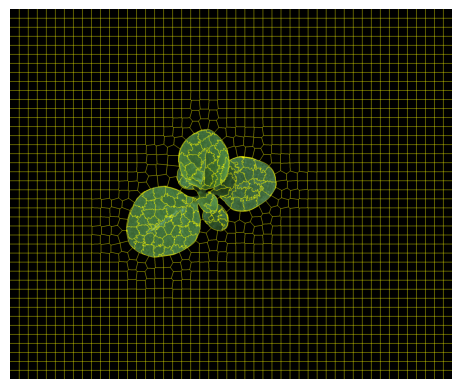

In [4]:
# Step 2: SLIC superpixel segmentation on the KMeans segmented output
segmentt = slic(image, n_segments=2000, compactness=5)
# show the output of SLIC
fig = plt.figure("Superpixels -- %d segments" % (2000))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segmentt))
plt.axis("off")

(-0.5, 2447.5, 2047.5, -0.5)

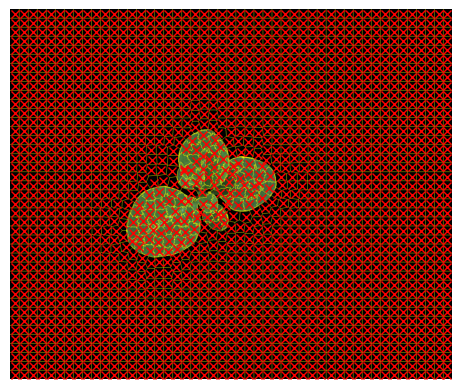

In [29]:
centroids = np.array([prop.centroid for prop in regionprops(segmentt)])
fig = plt.figure("Superpixels -- %d segments" % (2000))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segmentt))
ax.plot(centroids[:, 1], centroids[:, 0], 'rx')
plt.axis("off")

(2048, 2448)


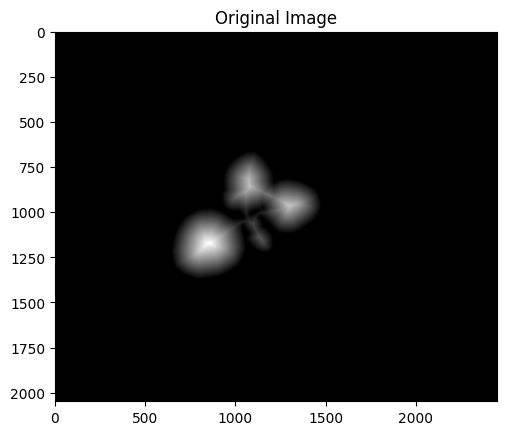

In [6]:
distTransform= cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)
print(distTransform.shape)
plt.imshow(distTransform, cmap=plt.get_cmap('gray'))
plt.title('Original Image')
plt.show()

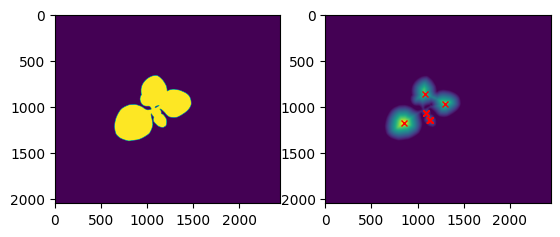

In [7]:
from skimage.feature import peak_local_max
coords = peak_local_max(distTransform, footprint=np.ones((100, 100)), labels=thresh1)
fig, (ax0, ax1) = plt.subplots(1, 2)
ax1.imshow(distTransform)
ax0.imshow(thresh1)
ax1.plot(coords[:, 1], coords[:, 0], 'rx',markersize=5)

In [8]:
A=coords
B=centroids
print(A.shape)
print(B.shape)
print(A)

(17, 2)
(1959, 2)
[[1174  849]
 [ 967 1297]
 [ 857 1078]
 [1138 1129]
 [1138 1130]
 [1143 1134]
 [1139 1131]
 [1140 1131]
 [1140 1132]
 [1141 1132]
 [1141 1133]
 [1142 1133]
 [1139 1130]
 [1067 1096]
 [1067 1097]
 [1068 1097]
 [1066 1096]]


In [ ]:
from scipy.spatial.distance import cdist
distancess = cdist(A, B)
print(distancess.shape)
print(distancess)

(17, 1959)
[[1413.92255799 1385.10044762 1357.81193469 ... 1703.43843446
  1746.51832226 1789.05016699]
 [1582.8291127  1542.5388974  1503.25521785 ... 1474.45057564
  1509.39598847 1544.40749156]
 [1342.02570765 1302.77789742 1264.70559815 ... 1707.91642067
  1744.39996847 1780.75615961]
 ...
 [1494.97424727 1459.18684547 1424.63197002 ... 1556.95359597
  1596.30080185 1635.38818022]
 [1495.67142114 1459.90110966 1425.36355012 ... 1556.33945526
  1595.70180485 1634.80350501]
 [1493.56017622 1457.77270176 1423.2186234  ... 1558.35698734
  1597.70061338 1636.78419469]]


1959


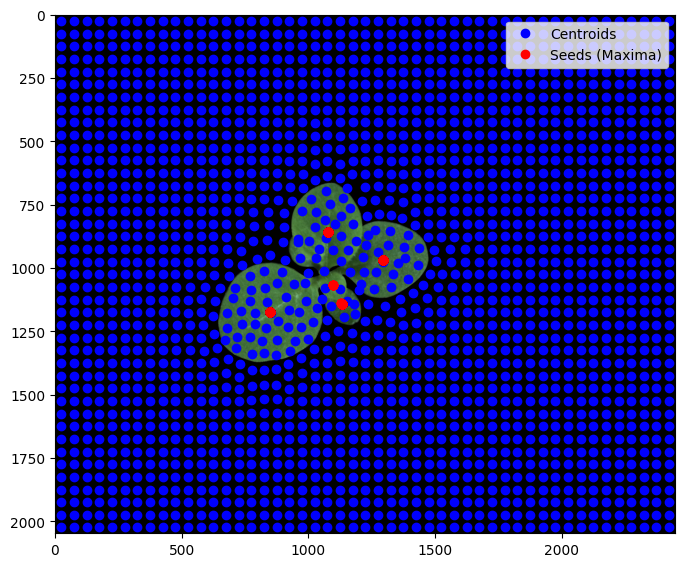

In [30]:
# Calculate distances between centroids and local maxima
distances = np.zeros((len(centroids), len(coords)))

for i, centroid in enumerate(centroids):
    distances[i] = np.linalg.norm(coords - centroid, axis=1)

# Find the index of the closest local maxima for each centroid
closest_maxima_indices = np.argmin(distances, axis=1)

# Extract the corresponding closest local maxima
seeds_maxima = coords[closest_maxima_indices]
print(len(seeds_maxima))
# Visualize the centroids and the corresponding closest local maxima
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)

# Plot centroids in blue
ax.plot(centroids[:, 1], centroids[:, 0], 'bo', label='Centroids')

# Plot closest local maxima in red
ax.plot(seeds_maxima[:, 1], seeds_maxima[:, 0], 'ro', label='Seeds (Maxima)')

ax.legend()
plt.show()


**Direct assigning coords_maximas as a marker**

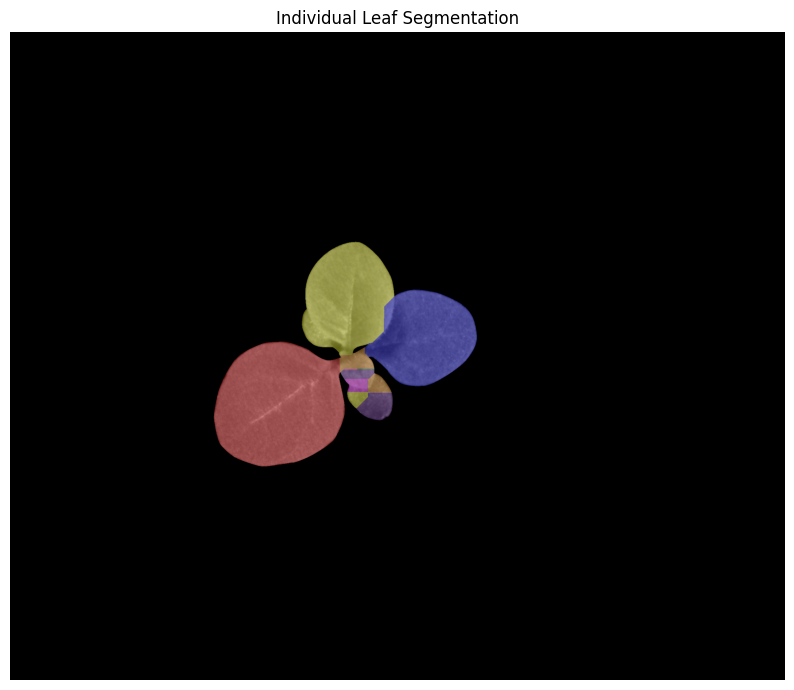

Number of segments: 17


In [10]:

from skimage.color import label2rgb

# Step 5: Create markers for watershed
markers = np.zeros_like(distTransform, dtype=np.int32)
for idx, coord in enumerate(coords, start=1):
    markers[int(coord[0]), int(coord[1])] = idx

# Step 6: Apply Watershed Algorithm
labels = watershed(-distTransform, markers, mask=thresh1)

# Step 7: Assign random colors to each label
label_colors = label2rgb(labels, image=image, bg_label=0)

# Step 8: Display individual leaf segments with different colors
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(label_colors)
ax.set_title('Individual Leaf Segmentation')
ax.axis('off')
plt.show()

num_segments = len(np.unique(labels)) - 1  # Exclude background label (0)
print("Number of segments:", num_segments)

**using first approach by calculating distance between coords_maxima and centroids and taking that location from segments where both lays and use it as a marker for watershed**

coord (17, 2)
centr (1959, 2)
(2048, 2448)
diss (2048, 2448)


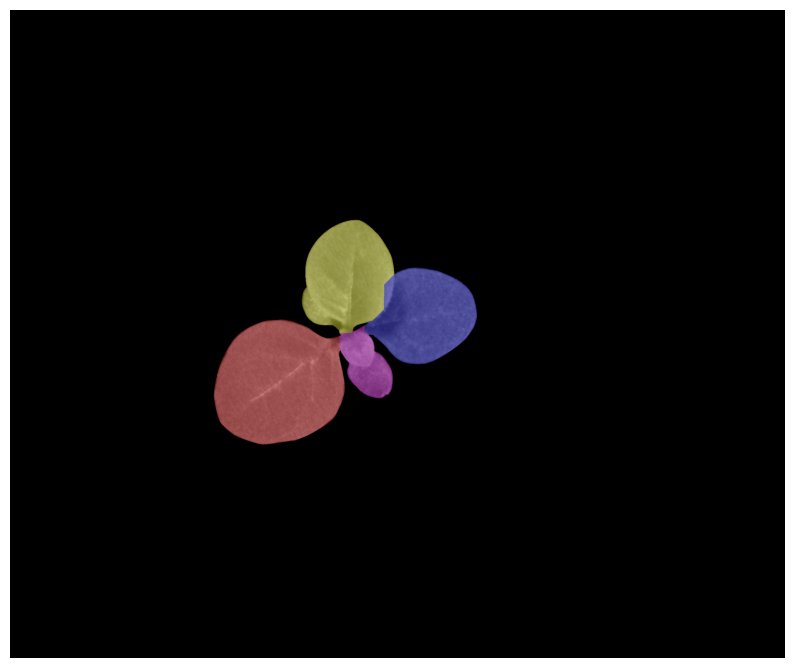

Number of segments: 6


In [103]:
# 1st approach
import cv2
import numpy as np
from skimage.segmentation import slic, watershed
from skimage.feature import peak_local_max
from skimage import io
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb

# Load the image
image = io.imread("/content/drive/MyDrive/plant016.png")

# Step 1: Convert the image to grayscale
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Thresholding to obtain a binary image
ret, thresh1 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY)

# Step 3: SLIC superpixel segmentation
segments = slic(image, n_segments=2000, compactness=5)

# Step 4: Calculate distance transform on the binary image
dist_transform = cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)

# Step 5: Identify local maxima in the distance map
coords_maxima = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=thresh1)
print("coord",coords_maxima.shape)
# Step 6: Extract centroids of superpixels
centroids = np.array([prop.centroid for prop in regionprops(segments)])
print("centr",centroids.shape)

di = np.linalg.norm(coords_maxima[:, np.newaxis, :] - centroids, axis=2)
min_distance_indices = np.argmin(di, axis=1)
mar = centroids[min_distance_indices]

# Step 7: Identify the most central superpixels within the leaves
#markers = np.zeros_like(img_gray, dtype=int)
print(markers.shape)
markers = np.zeros_like(img_gray, dtype=np.int32)
for idx, aq in enumerate(mar, start=1):
    markers[int(aq[0]), int(aq[1])] = idx

print("diss",markers.shape)
#print("arg",min_index)
# Step 8: Apply watershed segmentation
labels = watershed(-dist_transform, markers, mask=thresh1)

# Step 9: Assign random colors to each label
label_colors = label2rgb(labels, image=image, bg_label=0)

# Step 10: Display individual leaf segments with different colors
plt.figure(figsize=(10, 10))
plt.imshow(label_colors)
plt.axis("off")
plt.show()
num_segments = len(np.unique(labels)) - 1  # Exclude background label (0)
print("Number of segments:", num_segments)

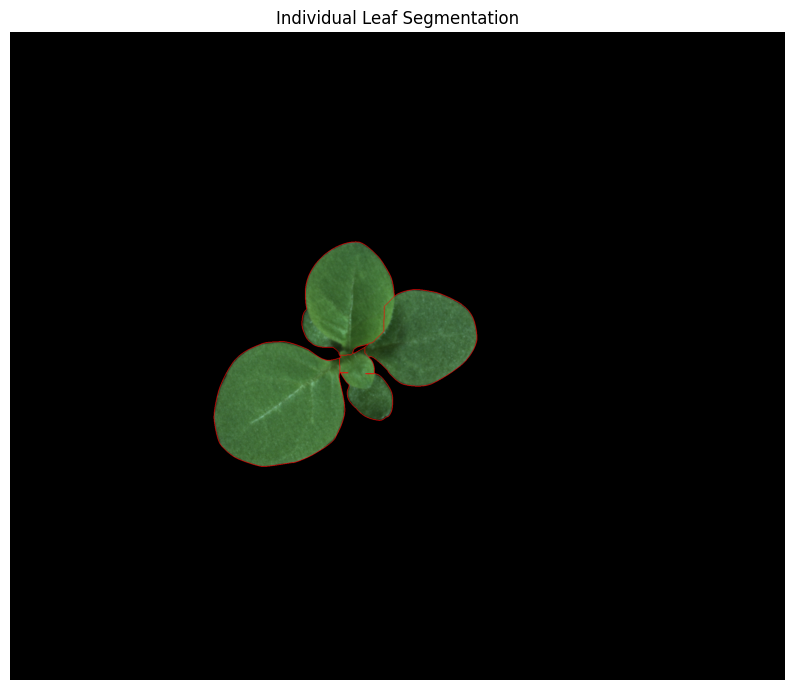

In [101]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mark_boundaries(image, labels, color=(1, 0, 0), mode='thick'))
plt.axis("off")
plt.title('Individual Leaf Segmentation')
plt.show()

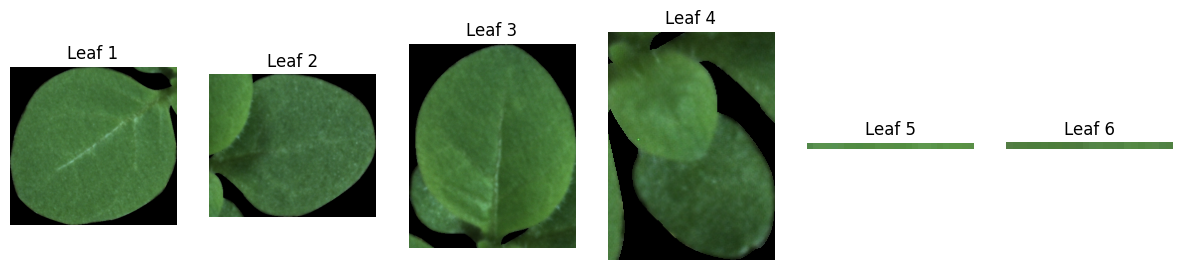

In [102]:
# Step 6: Extract individual leaf segments
individual_segments = []
for region in regionprops(labels):
    minr, minc, maxr, maxc = region.bbox
    leaf_segment = image[minr:maxr, minc:maxc]
    individual_segments.append(leaf_segment)

# Step 7: Display individual leaf segments
fig, axs = plt.subplots(1, len(individual_segments), figsize=(15, 15))
for i, segment in enumerate(individual_segments):
    axs[i].imshow(segment)
    axs[i].axis('off')
    axs[i].set_title(f'Leaf {i + 1}')

plt.show()

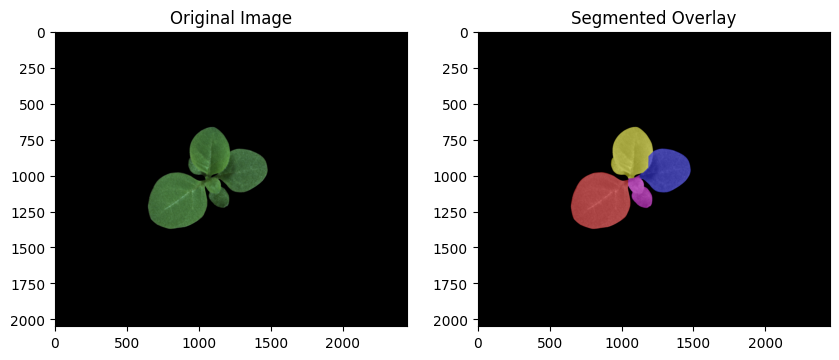

In [104]:
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.segmentation import mark_boundaries

# Load your original image and segmented labels
original_image = io.imread("/content/drive/MyDrive/plant016.png")
segmented_labels = labels

# Convert segmented labels to RGB color format
segmented_overlay = color.label2rgb(segmented_labels, image=original_image, bg_label=0, alpha=0.4, image_alpha=1)

# Display the original image and the overlay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(segmented_overlay)
axes[1].set_title('Segmented Overlay')

plt.show()


**using second approach by calculating distance between coords_maxima and centroids and taking that location from segments where both lays and use it as a marker for watershed**

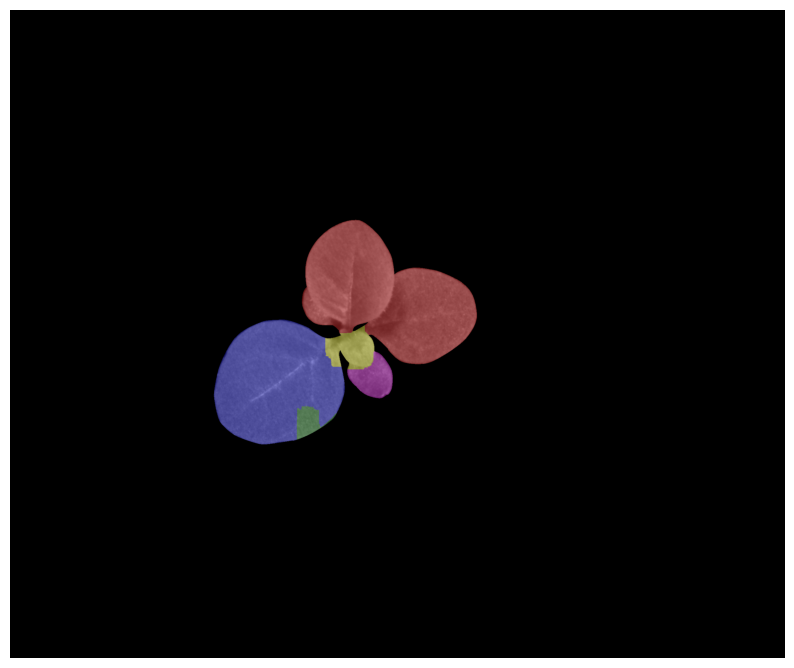

Number of segments: 5


In [14]:
# 2nd approach
import cv2
import numpy as np
from skimage.segmentation import slic, watershed
from skimage.feature import peak_local_max
from skimage import io
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb

# Load the image
image = io.imread("/content/drive/MyDrive/plant016.png")

# Step 1: Convert the image to grayscale
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Thresholding to obtain a binary image
ret, thresh1 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY)

# Step 3: SLIC superpixel segmentation
segments = slic(image, n_segments=2000, compactness=5)

# Step 4: Calculate distance transform on the binary image
dist_transform = cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)

# Step 5: Identify local maxima in the distance map
coords_maxima = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=thresh1)

# Step 6: Extract centroids of superpixels
centroids = np.array([prop.centroid for prop in regionprops(segments)])

# Step 7: Identify the most central superpixels within the leaves
markers = np.zeros_like(img_gray, dtype=int)
for coord in coords_maxima:
    distances = np.linalg.norm(centroids - coord[::-1], axis=1)
    min_index = np.argmin(distances)
    markers[segments == min_index + 1] = min_index + 1

# Step 8: Apply watershed segmentation
labels = watershed(-dist_transform, markers, mask=thresh1)

# Step 9: Assign random colors to each label
label_colors = label2rgb(labels, image=image, bg_label=0)

# Step 10: Display individual leaf segments with different colors
plt.figure(figsize=(10, 10))
plt.imshow(label_colors)
plt.axis("off")
plt.show()
num_segments = len(np.unique(labels)) - 1  # Exclude background label (0)
print("Number of segments:", num_segments)

**changing parameters**

(-0.5, 2447.5, 2047.5, -0.5)

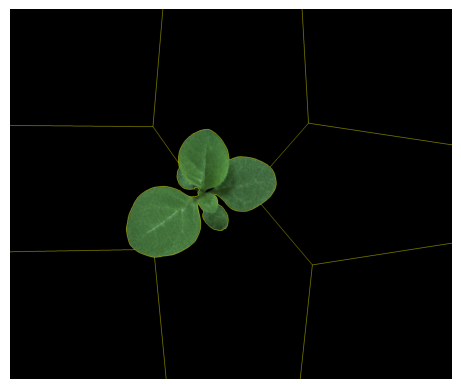

In [18]:

from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb

# Load the image
image = io.imread("/content/drive/MyDrive/plant016.png")

# Step 1: Convert the image to grayscale
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Thresholding to obtain a binary image
ret, thresh1 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY)

# Step 3: SLIC superpixel segmentation
segments = slic(image, n_segments=10, compactness=5)
fig = plt.figure("Superpixels -- %d segments" % (2000))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments))
plt.axis("off")

In [19]:
dist_transform = cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)
coords_maxima = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=thresh1)

In [22]:
centroids = np.array([prop.centroid for prop in regionprops(segments)])
print(centroids.shape)

(9, 2)


In [ ]:
# Calculate distances between centroids and local maxima
distances = np.zeros((len(centroids), len(coords)))

for i, centroid in enumerate(centroids):
    distances[i] = np.linalg.norm(coords - centroid, axis=1)

# Find the index of the closest local maxima for each centroid
closest_maxima_indices = np.argmin(distances, axis=1)

# Extract the corresponding closest local maxima
seeds_maxima = coords[closest_maxima_indices]
print(len(seeds_maxima))
# Visualize the centroids and the corresponding closest local maxima
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)

# Plot centroids in blue
ax.plot(centroids[:, 1], centroids[:, 0], 'bo', label='Centroids')

# Plot closest local maxima in red
ax.plot(seeds_maxima[:, 1], seeds_maxima[:, 0], 'ro', label='Seeds (Maxima)')

ax.legend()
plt.show()


(2048, 2448)
diss (2048, 2448)


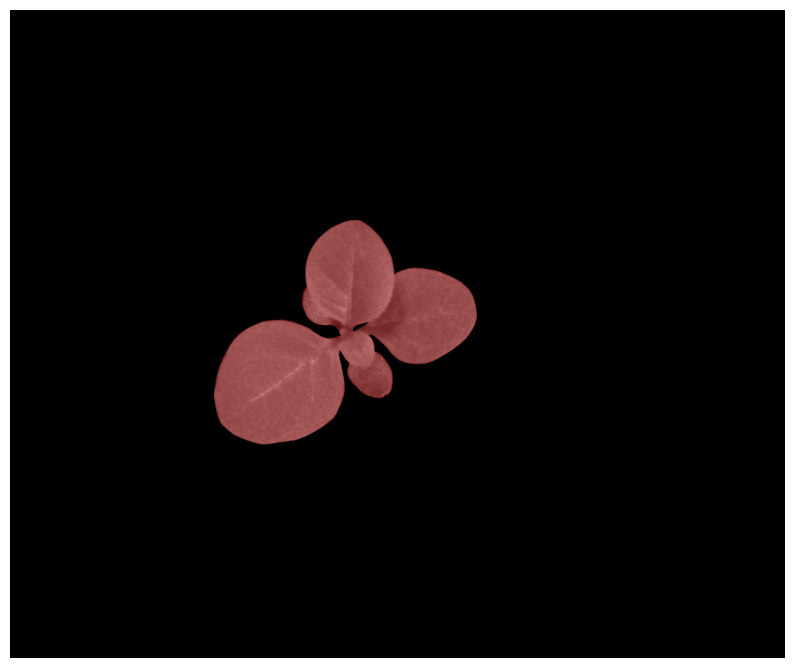

Number of segments: 1


In [27]:

di = np.linalg.norm(coords_maxima[:, np.newaxis, :] - centroids, axis=2)
min_distance_indices = np.argmin(di, axis=1)
mar = centroids[min_distance_indices]

# Step 7: Identify the most central superpixels within the leaves
#markers = np.zeros_like(img_gray, dtype=int)
print(markers.shape)
markers = np.zeros_like(img_gray, dtype=np.int32)
for idx, aq in enumerate(mar, start=1):
    markers[int(aq[0]), int(aq[1])] = idx


print("diss",markers.shape)
#print("arg",min_index)
# Step 8: Apply watershed segmentation
labels = watershed(-dist_transform, markers, mask=thresh1)

# Step 9: Assign random colors to each label
label_colors = label2rgb(labels, image=image, bg_label=0)

# Step 10: Display individual leaf segments with different colors
plt.figure(figsize=(10, 10))
plt.imshow(label_colors)
plt.axis("off")
plt.show()
num_segments = len(np.unique(labels)) - 1  # Exclude background label (0)
print("Number of segments:", num_segments)

<h1>For 2nd Image</h1>


In [31]:
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.measure import regionprops
from scipy.ndimage import distance_transform_edt, maximum_filter
from skimage.segmentation import watershed
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from scipy import ndimage as ndi
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import PIL.Image as Image
from skimage import io

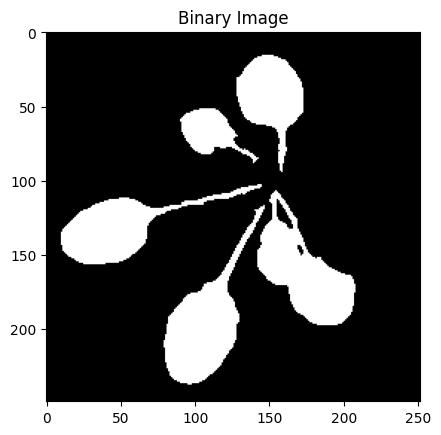

In [32]:
image = Image.open("/content/drive/MyDrive/ara2012_plant002_rgb.png")
#Convert the image file to a matrix
image = np.array(image)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap=plt.get_cmap('gray'))
plt.title('Binary Image')
plt.show()

(-0.5, 251.5, 248.5, -0.5)

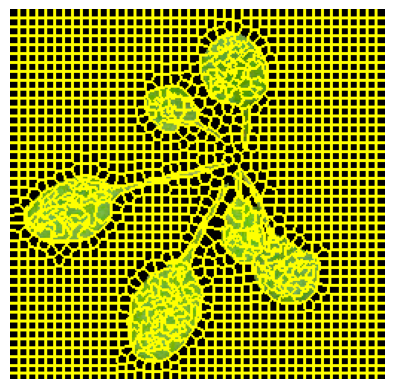

In [33]:
# Step 2: SLIC superpixel segmentation on the KMeans segmented output
segments = slic(image, n_segments=2000, compactness=5)
# show the output of SLIC
fig = plt.figure("Superpixels -- %d segments" % (2000))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments))
plt.axis("off")

(-0.5, 251.5, 248.5, -0.5)

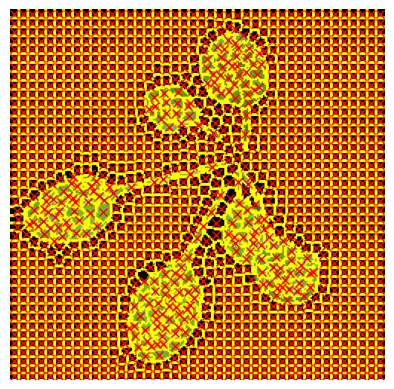

In [34]:
centroids = np.array([prop.centroid for prop in regionprops(segments)])
fig = plt.figure("Superpixels -- %d segments" % (2000))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments))
ax.plot(centroids[:, 1], centroids[:, 0], 'rx')
plt.axis("off")

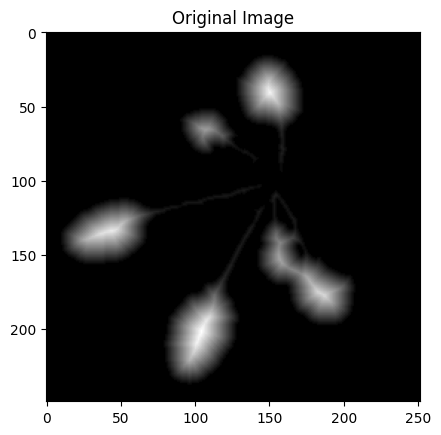

In [35]:
distTransform= cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)
plt.imshow(distTransform, cmap=plt.get_cmap('gray'))
plt.title('Original Image')
plt.show()

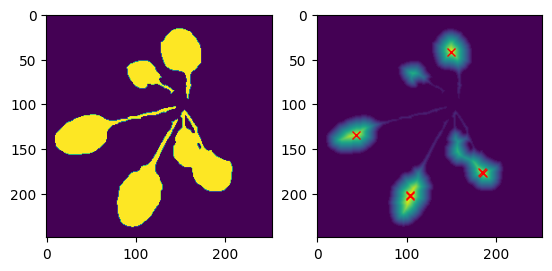

In [36]:
from skimage.feature import peak_local_max
coords = peak_local_max(distTransform, footprint=np.ones((100, 100)), labels=thresh1)
fig, (ax0, ax1) = plt.subplots(1, 2)
ax1.imshow(distTransform)
ax0.imshow(thresh1)
ax1.plot(coords[:, 1], coords[:, 0], 'rx')

In [37]:
A=coords
B=centroids
print(A.shape)
B.shape

(6, 2)


(1583, 2)

In [38]:
from scipy.spatial.distance import cdist
distancess = cdist(A, B)
print(distancess.shape)
print(distancess)

(6, 1583)
[[222.9450605  220.27823315 217.74411588 ... 140.09461089 145.78237205
  151.49422431]
 [223.83587737 221.17979112 218.65612271 ... 139.7730303  145.47336526
  151.1968915 ]
 [152.44179217 146.64412706 140.86340902 ... 222.96300142 225.35860312
  227.88703342]
 [137.89307452 136.2075622  134.76831972 ... 222.96300142 228.1633187
  233.4020137 ]
 [251.08663843 246.78431879 242.55411767 ...  87.90051194  91.61058891
   95.55364985]
 [253.22420895 248.91062653 244.66814259 ...  85.90983646  89.56840961
   93.46924628]]


**using second approach by calculating distance between coords_maxima and centroids and taking that location from segments where both lays and use it as a marker for watershed**

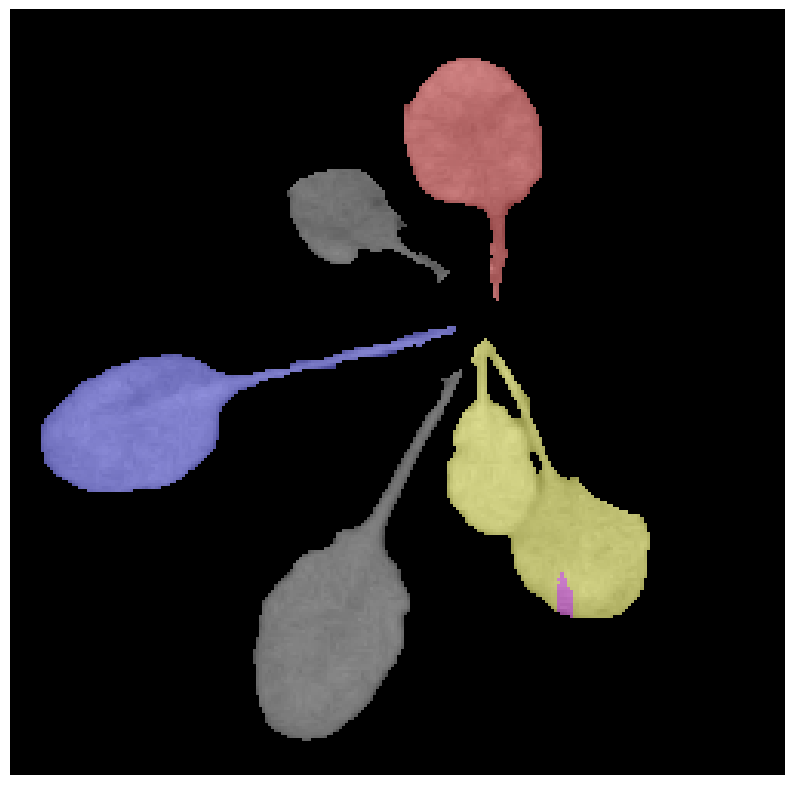

Number of segments: 4


In [44]:
import cv2
import numpy as np
from skimage.segmentation import slic, watershed
from skimage.feature import peak_local_max
from skimage import io
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb

# Load the image
image = io.imread("/content/drive/MyDrive/ara2012_plant002_rgb.png")

# Step 1: Convert the image to grayscale
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Thresholding to obtain a binary image
ret, thresh1 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY)

# Step 3: SLIC superpixel segmentation
segments = slic(image, n_segments=2000, compactness=5)

# Step 4: Calculate distance transform on the binary image
dist_transform = cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)

# Step 5: Identify local maxima in the distance map
coords_maxima = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=thresh1)

# Step 6: Extract centroids of superpixels
centroids = np.array([prop.centroid for prop in regionprops(segments)])

# Step 7: Identify the most central superpixels within the leaves
markers = np.zeros_like(img_gray, dtype=int)
for coord in coords_maxima:
    distances = np.linalg.norm(centroids - coord[::-1], axis=1)
    min_index = np.argmin(distances)
    markers[segments == min_index + 1] = min_index + 1

# Step 8: Apply watershed segmentation
labels = watershed(-dist_transform, markers, mask=thresh1)

# Step 9: Assign random colors to each label
label_colors = label2rgb(labels, image=image, bg_label=0)

# Step 10: Display individual leaf segments with different colors
plt.figure(figsize=(10, 10))
plt.imshow(label_colors)
plt.axis("off")
plt.show()
num_segments = len(np.unique(labels)) - 1  # Exclude background label (0)
print("Number of segments:", num_segments)

**Direct**

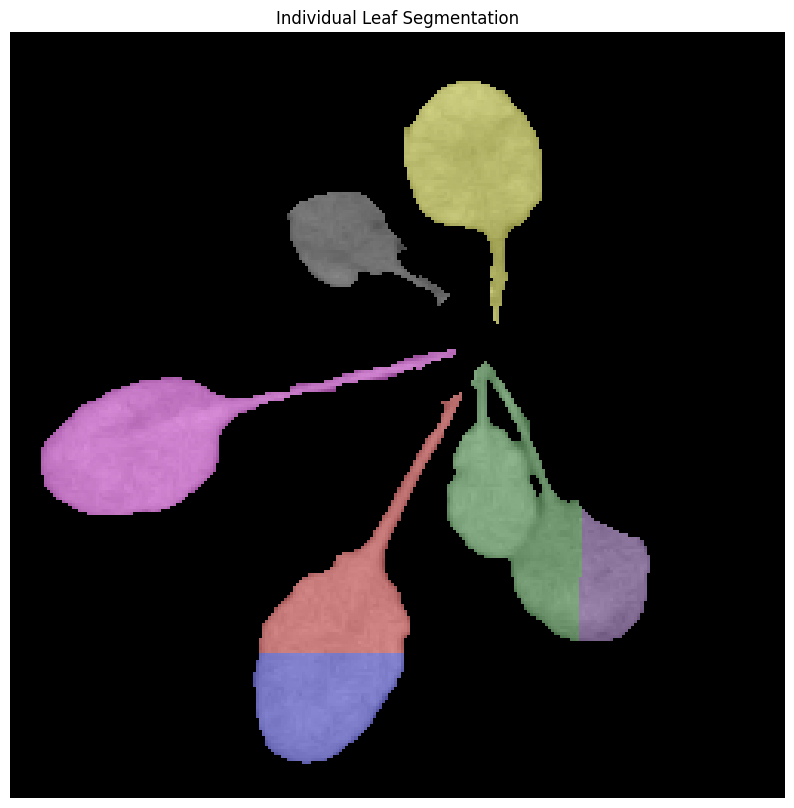

In [42]:

coords = peak_local_max(distTransform, footprint=np.ones((100, 100)), labels=thresh1)

# Step 5: Create markers for watershed
markers = np.zeros_like(distTransform, dtype=np.int32)
for idx, coord in enumerate(coords, start=1):
    markers[int(coord[0]), int(coord[1])] = idx

# Step 6: Apply Watershed Algorithm
labels = watershed(-distTransform, markers, mask=thresh1)

# Step 7: Assign random colors to each label
label_colors = label2rgb(labels, image=image, bg_label=0)

# Step 8: Display individual leaf segments with different colors
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(label_colors)
ax.set_title('Individual Leaf Segmentation')
ax.axis('off')
plt.show()

**using first approach by calculating distance between coords_maxima and centroids and taking that location from segments where both lays and use it as a marker for watershed**

coord (6, 2)
centr (1583, 2)
(249, 252)
diss (249, 252)


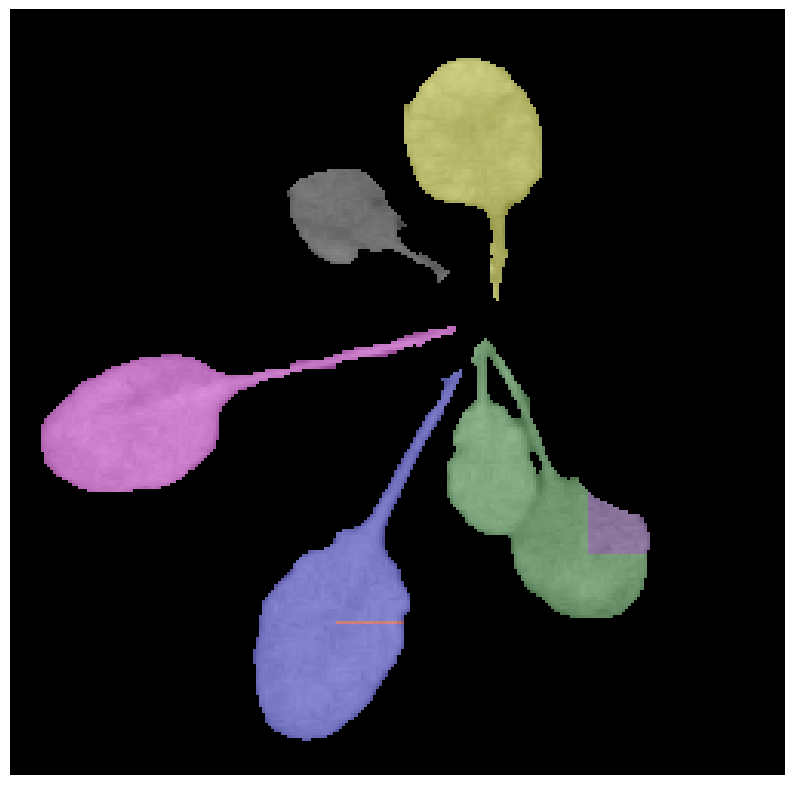

Number of segments: 6


In [43]:
import cv2
import numpy as np
from skimage.segmentation import slic, watershed
from skimage.feature import peak_local_max
from skimage import io
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb

# Load the image
image = io.imread("/content/drive/MyDrive/ara2012_plant002_rgb.png")

# Step 1: Convert the image to grayscale
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Thresholding to obtain a binary image
ret, thresh1 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY)

# Step 3: SLIC superpixel segmentation
segments = slic(image, n_segments=2000, compactness=5)

# Step 4: Calculate distance transform on the binary image
dist_transform = cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)

# Step 5: Identify local maxima in the distance map
coords_maxima = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=thresh1)
print("coord",coords_maxima.shape)
# Step 6: Extract centroids of superpixels
centroids = np.array([prop.centroid for prop in regionprops(segments)])
print("centr",centroids.shape)

di = np.linalg.norm(coords_maxima[:, np.newaxis, :] - centroids, axis=2)
min_distance_indices = np.argmin(di, axis=1)
mar = centroids[min_distance_indices]

# Step 7: Identify the most central superpixels within the leaves
#markers = np.zeros_like(img_gray, dtype=int)
print(markers.shape)
markers = np.zeros_like(img_gray, dtype=np.int32)
for idx, aq in enumerate(mar, start=1):
    markers[int(aq[0]), int(aq[1])] = idx

print("diss",markers.shape)
#print("arg",min_index)
# Step 8: Apply watershed segmentation
labels = watershed(-dist_transform, markers, mask=thresh1)

# Step 9: Assign random colors to each label
label_colors = label2rgb(labels, image=image, bg_label=0)

# Step 10: Display individual leaf segments with different colors
plt.figure(figsize=(10, 10))
plt.imshow(label_colors)
plt.axis("off")
plt.show()
num_segments = len(np.unique(labels)) - 1  # Exclude background label (0)
print("Number of segments:", num_segments)

**Lets play with parameters**

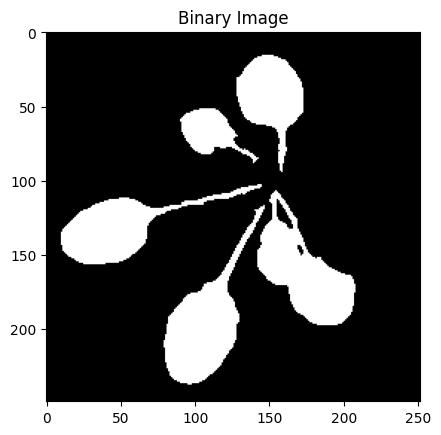

In [45]:
image = Image.open("/content/drive/MyDrive/ara2012_plant002_rgb.png")
#Convert the image file to a matrix
image = np.array(image)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap=plt.get_cmap('gray'))
plt.title('Binary Image')
plt.show()

(-0.5, 251.5, 248.5, -0.5)

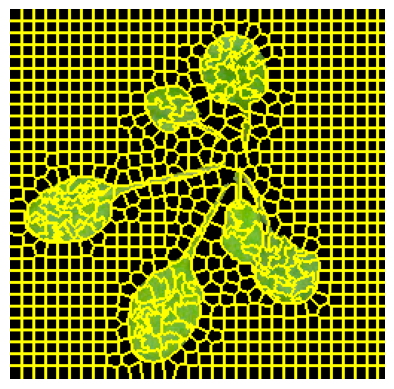

In [46]:
# Step 2: SLIC superpixel segmentation on the KMeans segmented output
segments = slic(image, n_segments=1000, compactness=5)
# show the output of SLIC
fig = plt.figure("Superpixels -- %d segments" % (2000))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments))
plt.axis("off")

(-0.5, 251.5, 248.5, -0.5)

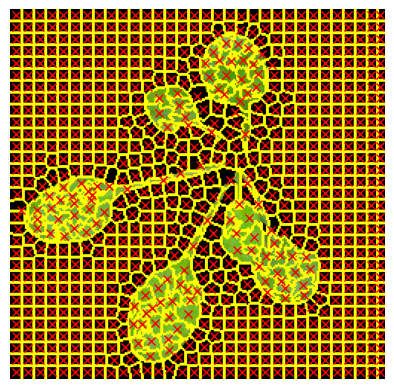

In [47]:
centroids = np.array([prop.centroid for prop in regionprops(segments)])
fig = plt.figure("Superpixels -- %d segments" % (1000))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments))
ax.plot(centroids[:, 1], centroids[:, 0], 'rx')
plt.axis("off")

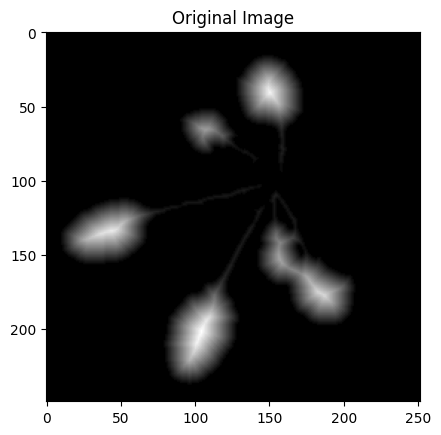

In [48]:
distTransform= cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)
plt.imshow(distTransform, cmap=plt.get_cmap('gray'))
plt.title('Original Image')
plt.show()

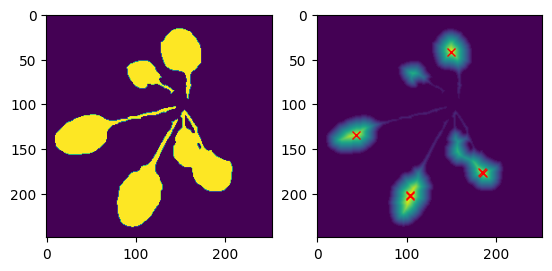

In [58]:
from skimage.feature import peak_local_max
coords = peak_local_max(distTransform, footprint=np.ones((100, 100)), labels=thresh1)
fig, (ax0, ax1) = plt.subplots(1, 2)
ax1.imshow(distTransform)
ax0.imshow(thresh1)
ax1.plot(coords[:, 1], coords[:, 0], 'rx')

In [59]:
print(centroids.shape)

(861, 2)


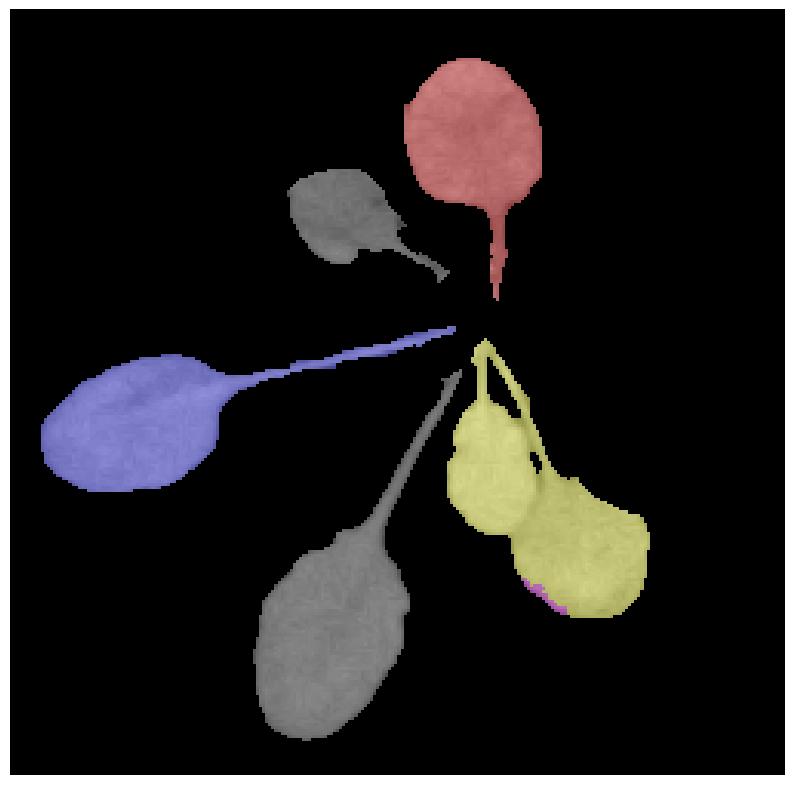

In [60]:
markers = np.zeros_like(img_gray, dtype=int)
for coord in coords_maxima:
    distances = np.linalg.norm(centroids - coord[::-1], axis=1)
    min_index = np.argmin(distances)
    markers[segments == min_index + 1] = min_index + 1

# Step 8: Apply watershed segmentation
labels = watershed(-dist_transform, markers, mask=thresh1)

# Step 9: Assign random colors to each label
label_colors = label2rgb(labels, image=image, bg_label=0)

# Step 10: Display individual leaf segments with different colors
plt.figure(figsize=(10, 10))
plt.imshow(label_colors)
plt.axis("off")
plt.show()

using First method

coord (6, 2)
centr (69, 2)
(150, 150)
diss (249, 252)


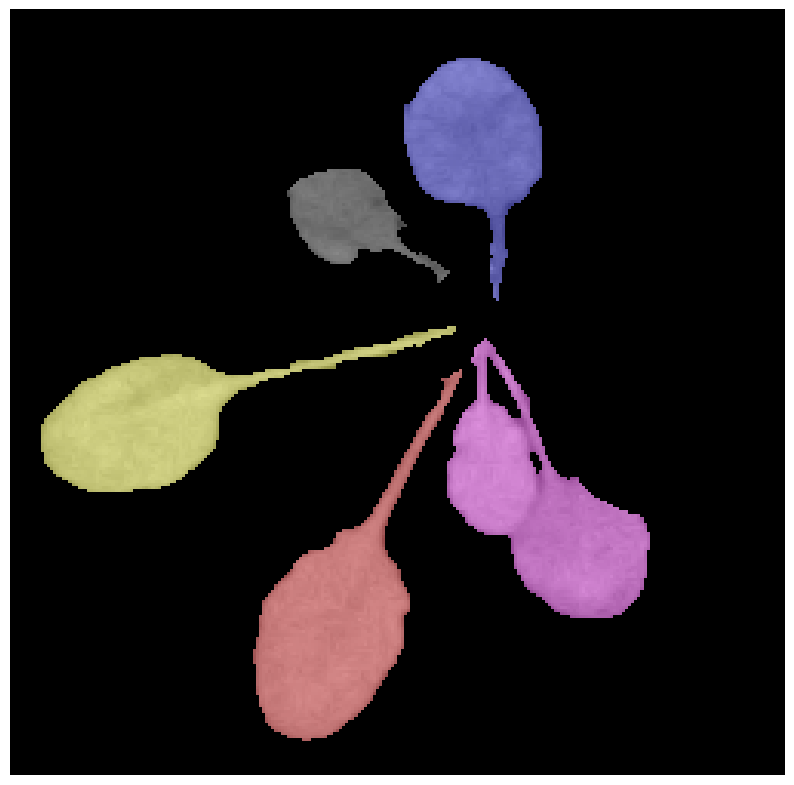

Number of segments: 4
(249, 252, 3)


In [84]:
import cv2
import numpy as np
from skimage.segmentation import slic, watershed
from skimage.feature import peak_local_max
from skimage import io
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb

# Load the image
image = io.imread("/content/drive/MyDrive/ara2012_plant002_rgb.png")

# Step 1: Convert the image to grayscale
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Thresholding to obtain a binary image
ret, thresh1 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY)

# Step 3: SLIC superpixel segmentation
segments = slic(image, n_segments=100, compactness=5)

# Step 4: Calculate distance transform on the binary image
dist_transform = cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)

# Step 5: Identify local maxima in the distance map
coords_maxima = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=thresh1)
print("coord",coords_maxima.shape)
# Step 6: Extract centroids of superpixels
centroids = np.array([prop.centroid for prop in regionprops(segments)])
print("centr",centroids.shape)

di = np.linalg.norm(coords_maxima[:, np.newaxis, :] - centroids, axis=2)
min_distance_indices = np.argmin(di, axis=1)
mar = centroids[min_distance_indices]

# Step 7: Identify the most central superpixels within the leaves
#markers = np.zeros_like(img_gray, dtype=int)
print(markers.shape)
markers = np.zeros_like(img_gray, dtype=np.int32)
for idx, aq in enumerate(mar, start=1):
    markers[int(aq[0]), int(aq[1])] = idx

print("diss",markers.shape)
#print("arg",min_index)
# Step 8: Apply watershed segmentation
labels = watershed(-dist_transform, markers, mask=thresh1)

# Step 9: Assign random colors to each label
label_colors = label2rgb(labels, image=image, bg_label=0)

# Step 10: Display individual leaf segments with different colors
plt.figure(figsize=(10, 10))
plt.imshow(label_colors)
plt.axis("off")
plt.show()
num_segments = len(np.unique(labels)) - 1  # Exclude background label (0)
print("Number of segments:", num_segments)
print(image.shape)

<h1>For Third Image</h1>


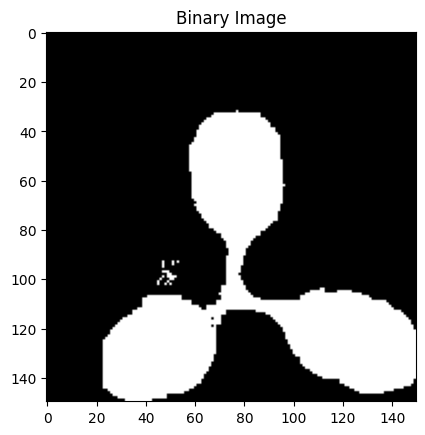

In [87]:
image = Image.open("/content/drive/MyDrive/plant098_rgb.png")
#Convert the image file to a matrix
image = np.array(image)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap=plt.get_cmap('gray'))
plt.title('Binary Image')
plt.show()

In [88]:
rgb_image = image[:, :, :3]

(-0.5, 149.5, 149.5, -0.5)

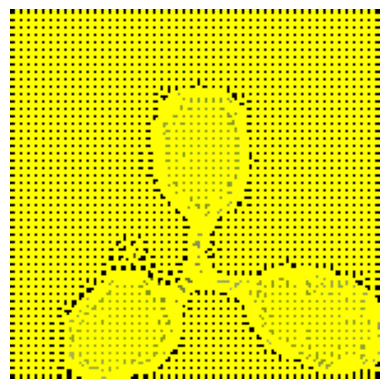

In [90]:
segments = slic(rgb_image, n_segments=2000, compactness=5)
# show the output of SLIC

fig = plt.figure("Superpixels -- %d segments" % (2000))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(rgb_image, segments))
plt.axis("off")


(-0.5, 149.5, 149.5, -0.5)

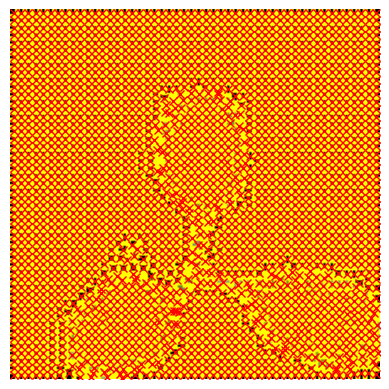

In [91]:
centroids = np.array([prop.centroid for prop in regionprops(segments)])
fig = plt.figure("Superpixels -- %d segments" % (1000))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(rgb_image, segments))
ax.plot(centroids[:, 1], centroids[:, 0], 'rx')
plt.axis("off")

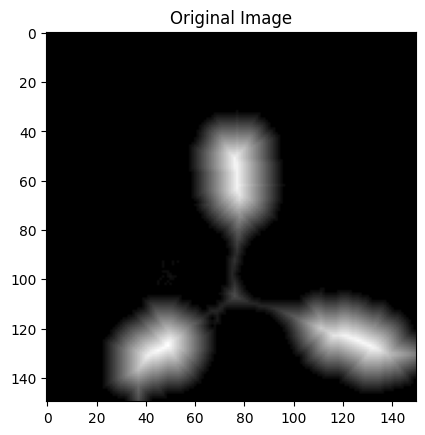

In [92]:
distTransform= cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)
plt.imshow(distTransform, cmap=plt.get_cmap('gray'))
plt.title('Original Image')
plt.show()

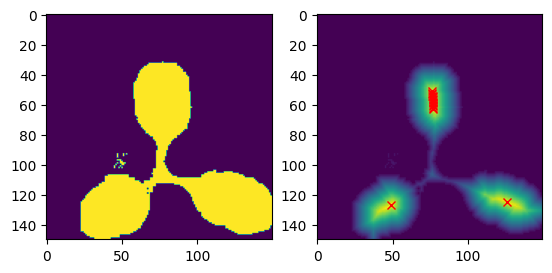

In [97]:
from skimage.feature import peak_local_max
coords = peak_local_max(distTransform, footprint=np.ones((100, 100)), labels=thresh1)
fig, (ax0, ax1) = plt.subplots(1, 2)
ax1.imshow(distTransform)
ax0.imshow(thresh1)
ax1.plot(coords[:, 1], coords[:, 0], 'rx')

coord (16, 2)
centr (75, 2)
(249, 252)
diss (150, 150)


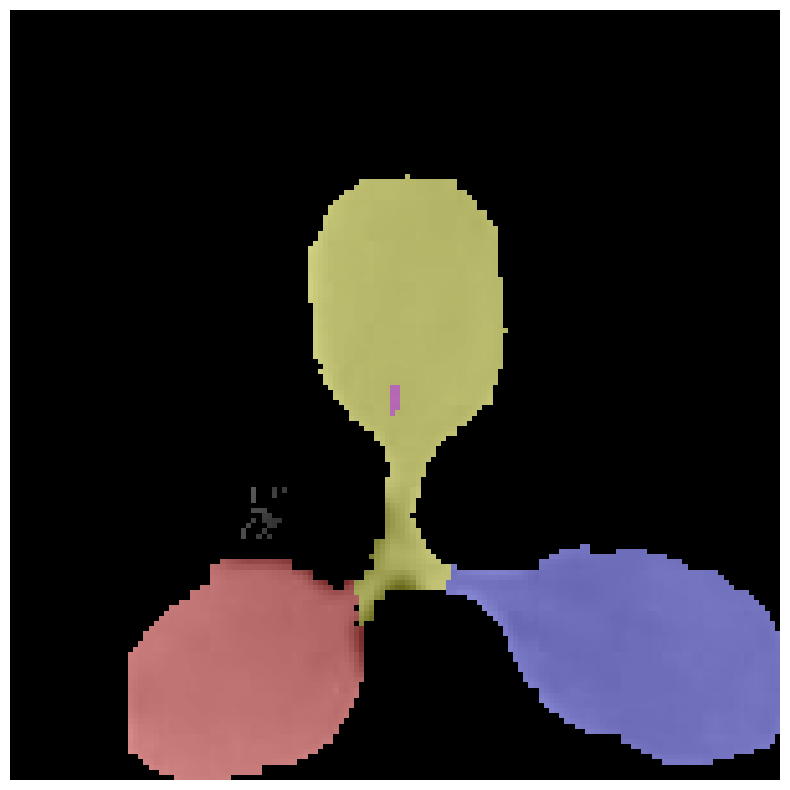

Number of segments: 4


In [95]:
import cv2
import numpy as np
from skimage.segmentation import slic, watershed
from skimage.feature import peak_local_max
from skimage import io
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb

# Load the image
image = io.imread("/content/drive/MyDrive/plant098_rgb.png")
rgb_image = image[:, :, :3]
# Step 1: Convert the image to grayscale
img_gray = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)

# Step 2: Thresholding to obtain a binary image
ret, thresh1 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY)

# Step 3: SLIC superpixel segmentation
segments = slic(rgb_image, n_segments=100, compactness=5)

# Step 4: Calculate distance transform on the binary image
dist_transform = cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)

# Step 5: Identify local maxima in the distance map
coords_maxima = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=thresh1)
print("coord",coords_maxima.shape)
# Step 6: Extract centroids of superpixels
centroids = np.array([prop.centroid for prop in regionprops(segments)])
print("centr",centroids.shape)

di = np.linalg.norm(coords_maxima[:, np.newaxis, :] - centroids, axis=2)
min_distance_indices = np.argmin(di, axis=1)
mar = centroids[min_distance_indices]

# Step 7: Identify the most central superpixels within the leaves
#markers = np.zeros_like(img_gray, dtype=int)
print(markers.shape)
markers = np.zeros_like(img_gray, dtype=np.int32)
for idx, aq in enumerate(mar, start=1):
    markers[int(aq[0]), int(aq[1])] = idx

print("diss",markers.shape)
#print("arg",min_index)
# Step 8: Apply watershed segmentation
labels = watershed(-dist_transform, markers, mask=thresh1)

# Step 9: Assign random colors to each label
label_colors = label2rgb(labels, image=rgb_image, bg_label=0)

# Step 10: Display individual leaf segments with different colors
plt.figure(figsize=(10, 10))
plt.imshow(label_colors)
plt.axis("off")
plt.show()
num_segments = len(np.unique(labels)) - 1  # Exclude background label (0)
print("Number of segments:", num_segments)